# Exploring the Data

- [Imports](#imports)   
    - [First Glance](#firstglance)
- [Data](#data)
    - [2007 Data](#2007data)
    - [2017 Data](#2017data)
    - [Target Variable](#targetvariable)
    - [Reference Tables](#referencetables)
- [Extracting State Data](#extractingstatedata)
    - [New Mexico](#newmexico)
    - [Nebraska](#nebraska)
- [Initial Snapshots of the data](#initialsnapshot)
- [Null Values](#nullvalues)
    - [Full Missing Values](#fullnull)
    - [Partial Missing: High Nullity](#partialnull)
    - [Imputing null values with mean](#simpleimputer)
- [Save Clean Files](#exportclean)

# Imports   <a id=imports></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

import autoreload
%load_ext autoreload
%autoreload 2
import python_code.Scripts as sc
import python_code.Reference as ref

### _First glance..._ <a id=firstglance></a>
These datasets contains information about each household that received SNAP benefits in 2007 and 2017.  Each household is representated by a record and goes on to record information about each member of the household.  

For our purposes, we will break this down into two states of interest: New Mexico and Nebraska.  This is due to a previous geographical analysis of emerging hot and cold spots targeting San Juan County, New Mexico as a new hot spot and Cherry County, Nebraska as a new cold spot.

# Data  <a id=data><a>

### _2007 Data_  <a id=2007data><a>
First, we are starting with the 2007 dataset downloaded from the [USDA site](https://www.fns.usda.gov/resource/snap-quality-control-data)

In [2]:
snap07 = pd.read_spss('./data/qc_pub_fy2007.sav')

In [3]:
snap07.head(5)

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,NDISCA7,NDISCA8,NDISCA9,NDISCA10,NDISCA11,NDISCA12,NDISCA13,NDISCA14,NDISCA15,NDISCA16
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
snap07.shape

(47469, 769)

### _2017 Data_  <a id=2017data><a>

In [5]:
snap17 = pd.read_csv('./data/qc_pub_fy2017.csv')

In [6]:
snap17.head(5)

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,WORK12,WORK13,WORK14,WORK15,WORK16,FSNONCIT,FSDIS,FSELDER,FSKID,STATENAME
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,0,0,Connecticut
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,Connecticut
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,Connecticut
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,0,0,Connecticut
4,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,1,0,Connecticut


### _Target Variable_  <a id=targetvariable><a>

In [7]:
# 2007: 1 = Not eligible, 2 = Eligible
snap07['CAT_ELIG'].value_counts()

2.0    25134
1.0    22335
Name: CAT_ELIG, dtype: int64

In [8]:
# 2017: 0 = Not eligible, 1 = Reported eligible, 2= Recorded eligible
snap17['CAT_ELIG'].value_counts()

1    36223
0     7012
2     2295
Name: CAT_ELIG, dtype: int64

__Observations:__ I am going to change the target variable in both datasets to a dictionary of:
- 0 = Not Eligible
- 1 = Eligible

In [9]:
snap07['CAT_ELIG'] = snap07['CAT_ELIG'].replace(2,0)
snap17['CAT_ELIG'] = snap17['CAT_ELIG'].replace(2,1)

In [10]:
snap07['CAT_ELIG'].value_counts()

0.0    25134
1.0    22335
Name: CAT_ELIG, dtype: int64

In [11]:
snap17['CAT_ELIG'].value_counts()

1    38518
0     7012
Name: CAT_ELIG, dtype: int64

In [12]:
print(f'2017 dataset: {snap17.shape} VS 2007 dataset: {snap07.shape}')

2017 dataset: (45530, 814) VS 2007 dataset: (47469, 769)


__Observations:__ Less people nationally applied for SNAP benefits in 2017 as opposed to 2007.  This probably had to do with stronger national economic factors such as employment opportunities.  Also, 45 columns of features were added to the dataset.

### _Reference tables_  <a id=referencetables><a>

In [13]:
print(f'Unit Demo, 2007 is {ref.unit07_demo.shape[0]} and 2017 is {ref.unit17_demo.shape[0]}')
print(f'Unit Assets, 2007 is {ref.unit07_assets.shape[0]} and 2017 is {ref.unit17_assets.shape[0]}')
print(f'Unit ExDed, 2007 is {ref.unit07_exded.shape[0]} and 2017 is {ref.unit17_exded.shape[0]}')
print(f'Unit Inc, 2007 is {ref.unit07_inc.shape[0]} and 2017 is {ref.unit17_inc.shape[0]}')
print(f'Pers Char, 2007 is {ref.per07_char.shape[0]} and 2017 is {ref.per17_char.shape[0]}')
print(f'Pers Inc, 2007 is {ref.per07_inc.shape[0]} and 2017 is {ref.per17_inc.shape[0]}')

Unit Demo, 2007 is 22 and 2017 is 31
Unit Assets, 2007 is 7 and 2017 is 11
Unit ExDed, 2007 is 27 and 2017 is 27
Unit Inc, 2007 is 26 and 2017 is 27
Pers Char, 2007 is 14 and 2017 is 17
Pers Inc, 2007 is 20 and 2017 is 21


__Observations:__ From 2007 to 2017, every category obtained more columns except for Expenses and Deductables.

# Extracting state data  <a id=extractingstatedata><a>

### _New Mexico_  <a id=newmexico><a>

In [14]:
#save New Mexico records
nm07 = snap07.loc[snap07['STATE'] == 35].astype('float64')
nm07_target = nm07['CAT_ELIG']
nm07.to_csv('./data/nm07.csv',index=None)

In [15]:
nm17 = snap17.loc[snap17['STATE'] == 35]
nm17_target = nm17['CAT_ELIG']
nm17 = nm17.drop(columns = ['STATENAME'])
nm17 = nm17.astype('float64')
nm17.to_csv('./data/nm17.csv',index=None)

In [16]:
#New Mexico dataframe
df_nm07 = pd.read_csv('./data/nm07.csv')
df_nm07

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,NDISCA7,NDISCA8,NDISCA9,NDISCA10,NDISCA11,NDISCA12,NDISCA13,NDISCA14,NDISCA15,NDISCA16
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1251,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1252,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1253,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_nm17 = pd.read_csv('./data/nm17.csv')
df_nm17

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,WORK11,WORK12,WORK13,WORK14,WORK15,WORK16,FSNONCIT,FSDIS,FSELDER,FSKID
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
960,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
961,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
962,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0


In [18]:
df_nm07['CAT_ELIG'].value_counts()

0.0    813
1.0    442
Name: CAT_ELIG, dtype: int64

In [19]:
df_nm17['CAT_ELIG'].value_counts()

1.0    964
Name: CAT_ELIG, dtype: int64

### _Nebraska_  <a id=nebraska><a>

In [20]:
# Save Nebrasks records
ne07 = snap07.loc[snap07['STATE'] == 31].astype('float64')
ne07_target = ne07['CAT_ELIG']
ne07.to_csv('./data/ne07.csv',index=None)

In [21]:
ne17 = snap17.loc[snap17['STATE'] == 31]
ne17_target = ne17['CAT_ELIG']
ne17 = ne17.drop(columns = ['STATENAME'])
ne17 = ne17.astype('float64')
ne17.to_csv('./data/ne17.csv',index=None)

In [22]:
#Nebraska dataframe
df_ne07 = pd.read_csv('./data/ne07.csv')
df_ne07

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,NDISCA7,NDISCA8,NDISCA9,NDISCA10,NDISCA11,NDISCA12,NDISCA13,NDISCA14,NDISCA15,NDISCA16
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
787,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
789,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_ne17 = pd.read_csv('./data/ne17.csv')
df_ne17

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,WORK11,WORK12,WORK13,WORK14,WORK15,WORK16,FSNONCIT,FSDIS,FSELDER,FSKID
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
890,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
891,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0
892,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0


In [24]:
df_ne07['CAT_ELIG'].value_counts()

0.0    505
1.0    286
Name: CAT_ELIG, dtype: int64

In [25]:
df_ne17['CAT_ELIG'].value_counts()

1.0    894
Name: CAT_ELIG, dtype: int64

__Observation:__ We can see there are 1255 people who applied for SNAP in New Mexico, opposed to 791 applications in Nebraska in 2007.  

There were significantly more people in both states (Nebraska: 894, New Mexico:  964) on SNAP in 2017.  Due to a dramatic change, I suspect that it was due to more being eligible because of a change in qualifications.  

# Initial Snapshots of the data  <a id=initialsnapshot><a>

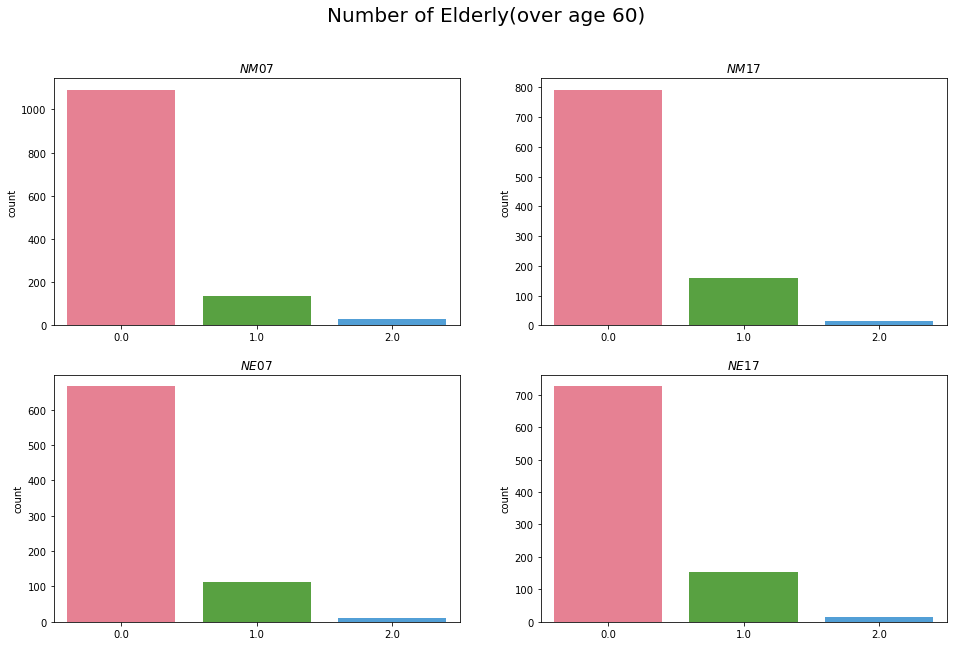

In [26]:
sc.plot_simple_features('FSNELDER','elderly',"Number of Elderly(over age 60)")

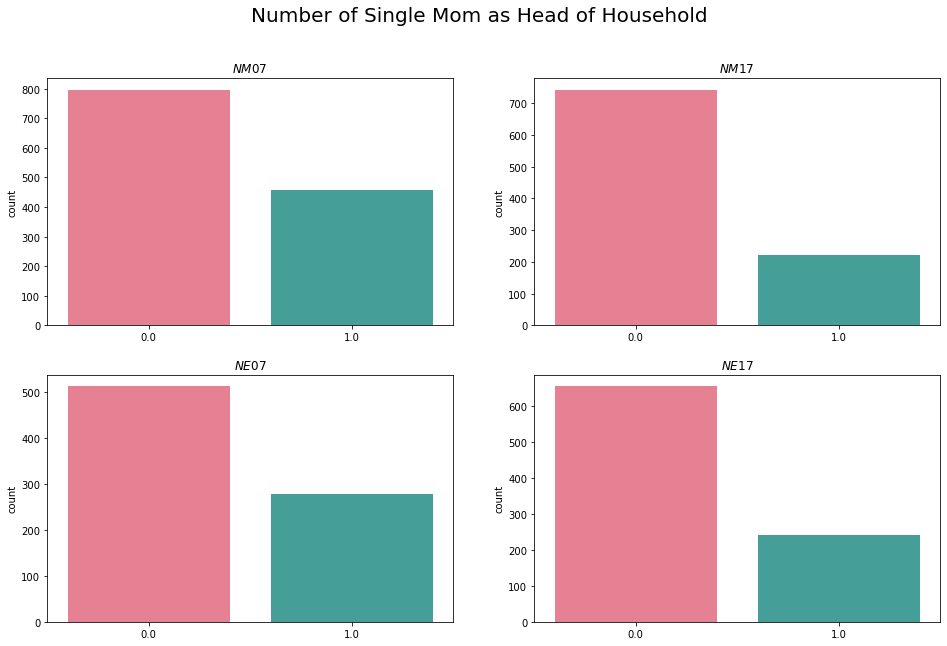

In [27]:
#single-female head of household - FSNGMOM
sc.plot_simple_features('FSNGMOM','single_mom',"Number of Single Mom as Head of Household")

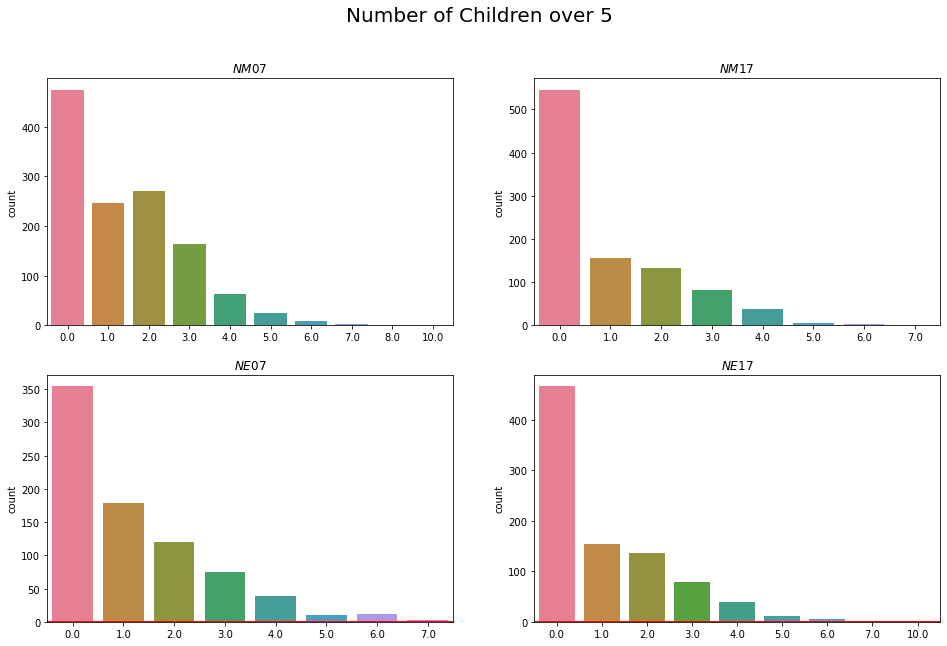

In [28]:
#number of children - FSNKID
sc.plot_simple_features('FSNKID','no_children',"Number of Children over 5")

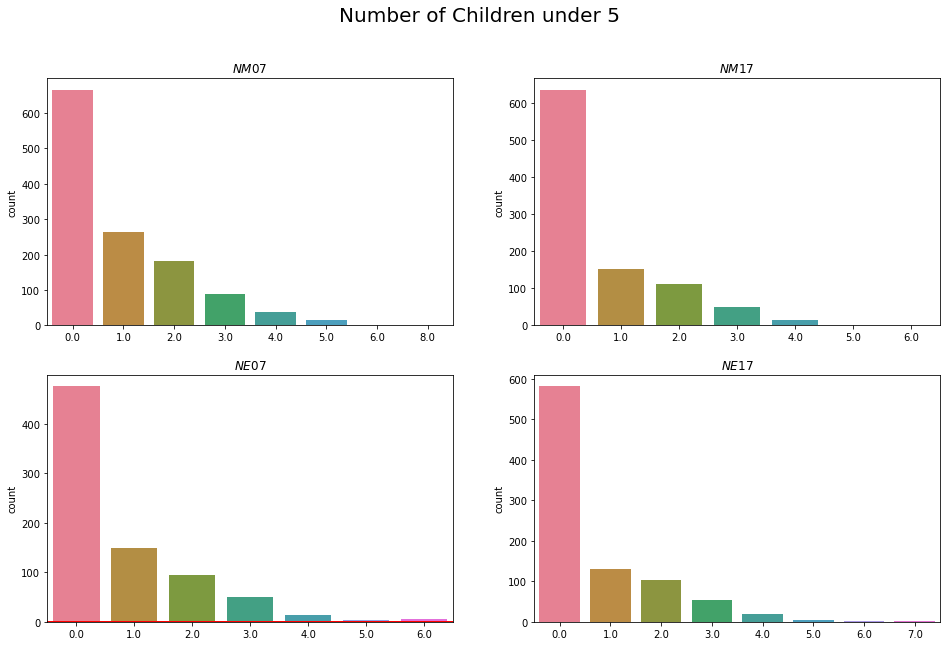

In [29]:
#number of children under 5 = FSNK5T17
sc.plot_simple_features('FSNK5T17','no_toddler',"Number of Children under 5")

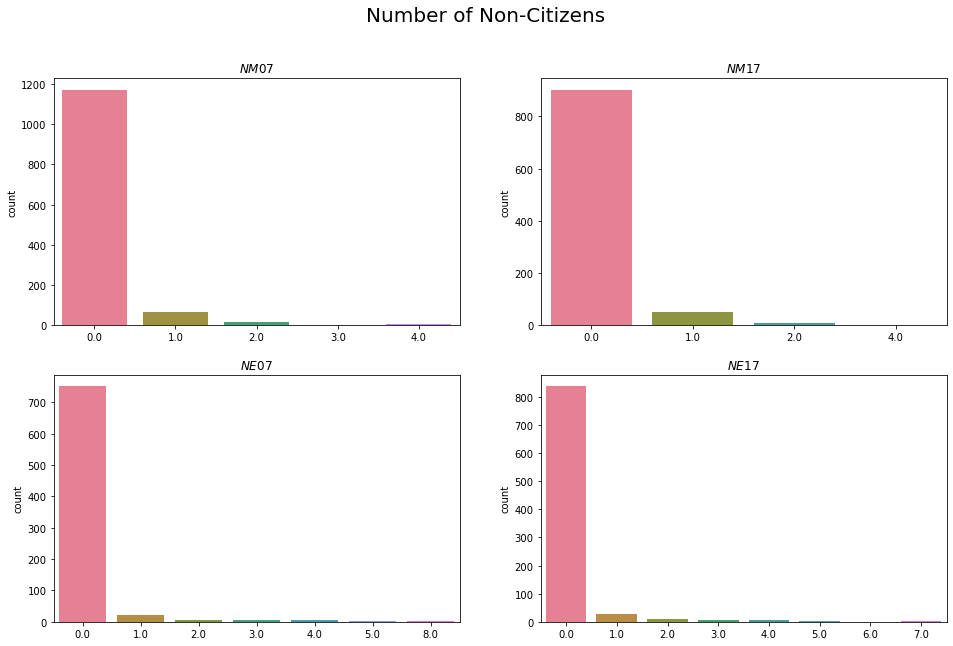

In [30]:
#number of noncitizens in unit = FSNONCIT
sc.plot_simple_features('FSNONCIT','non_citiz',"Number of Non-Citizens")

# Null Values   <a id=nullvalues><a>

This will be a long section dedicated to an initial reduction of columns by different treatments of null values.

### _Full Missing values_   <a id=fullnull><a>
There are many columns that have no data in them at all, we will remove those.

___New Mexico___

In [31]:
with pd.option_context('display.max_rows', None):
    print(df_nm07.isnull().sum().sort_values(ascending=False)[:96])

NDISCA16    1255
CTZN15      1255
WRKREG13    1255
WRKREG14    1255
WRKREG15    1255
VERIF9      1255
VERIF8      1255
VERIF7      1255
VERIF6      1255
AGE16       1255
AGE15       1255
AGE14       1255
AGE13       1255
WRKREG16    1255
YRSED13     1255
YRSED14     1255
YRSED15     1255
YRSED16     1255
DISCOV9     1255
DISCOV8     1255
DISCOV7     1255
DISCOV6     1255
REL16       1255
TIMEPER8    1255
REL14       1255
CTZN16      1255
CTZN14      1255
ABWDST13    1255
SEX13       1255
TIMEPER6    1255
TIMEPER9    1255
RACETH16    1255
E_FINDG6    1255
E_FINDG7    1255
FSUN13      1255
FSUN14      1255
FSUN15      1255
FSUN16      1255
RACETH15    1255
RACETH14    1255
RACETH13    1255
E_FINDG8    1255
E_FINDG9    1255
EMPSTB13    1255
CTZN13      1255
OCCDATE9    1255
OCCDATE8    1255
OCCDATE7    1255
OCCDATE6    1255
SEX16       1255
SEX15       1255
SEX14       1255
REL13       1255
REL15       1255
ABWDST14    1255
NATURE8     1255
NATURE6     1255
EMPSTA13    1255
EMPSTA14    12

In [32]:
#Remove those columns.
first_cut = df_nm07.isnull().sum().sort_values(ascending=False)[:96]
first_cut_df = pd.DataFrame([first_cut])
first_cut_df.T
fc_list = list(first_cut_df.columns)

#remove them
nm07 = df_nm07.drop(fc_list,axis=1)
nm07

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,NDISCA3,NDISCA4,NDISCA5,NDISCA6,NDISCA7,NDISCA8,NDISCA9,NDISCA10,NDISCA11,NDISCA12
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1251,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1252,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1253,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
with pd.option_context('display.max_rows', None):
    print(df_nm17.isnull().sum().sort_values(ascending=False)[:165])

DPCOST15    964
SEX12       964
OCCDATE8    964
CTZN10      964
FSUN16      964
FSUN15      964
FSUN14      964
FSUN13      964
FSUN12      964
FSUN11      964
FSUN10      964
OCCDATE9    964
CTZN11      964
CTZN12      964
CTZN13      964
CTZN14      964
CTZN15      964
CTZN16      964
TIMEPER4    964
TIMEPER5    964
TIMEPER6    964
TIMEPER7    964
TIMEPER8    964
TIMEPER9    964
YRSED10     964
OCCDATE7    964
OCCDATE6    964
DIS10       964
RACETH11    964
SEX14       964
SEX15       964
SEX16       964
VERIF4      964
VERIF5      964
VERIF6      964
VERIF7      964
VERIF8      964
VERIF9      964
RACETH10    964
RACETH12    964
DIS11       964
RACETH13    964
RACETH14    964
RACETH15    964
RACETH16    964
OCCDATE4    964
OCCDATE5    964
DIS15       964
DIS14       964
DIS13       964
DIS12       964
YRSED11     964
YRSED12     964
YRSED13     964
DPCOST16    964
EMPSTB14    964
EMPSTB15    964
EMPSTB16    964
WRKREG10    964
WRKREG11    964
WRKREG12    964
WRKREG13    964
WRKREG14

In [34]:
#Remove those columns.
first_cut = df_nm17.isnull().sum().sort_values(ascending=False)[:165]
first_cut_df = pd.DataFrame([first_cut])
first_cut_df.T
fc_list = list(first_cut_df.columns)

#remove them
nm17 = df_nm17.drop(fc_list,axis=1)
nm17

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,REL1,...,WORK4,WORK5,WORK6,WORK7,WORK8,WORK9,FSNONCIT,FSDIS,FSELDER,FSKID
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
960,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
961,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
962,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0


___Nebraska___

In [35]:
with pd.option_context('display.max_rows', None):
    print(df_ne07.isnull().sum().sort_values(ascending=False)[:144])

NDISCA16    791
FSUN12      791
DISCOV9     791
EMPSTB16    791
E_FINDG9    791
E_FINDG8    791
E_FINDG7    791
E_FINDG6    791
RACETH10    791
RACETH11    791
RACETH12    791
RACETH13    791
RACETH14    791
RACETH15    791
FSUN16      791
FSUN15      791
FSUN14      791
DISCOV8     791
DISCOV7     791
SEX16       791
EMPSTA12    791
AGE16       791
EMPSTA16    791
EMPSTA15    791
EMPSTA14    791
EMPSTA13    791
DISCOV6     791
EMPSTA11    791
SEX15       791
EMPSTA10    791
SEX10       791
SEX11       791
SEX12       791
SEX13       791
SEX14       791
FSUN13      791
FSUN11      791
AGE13       791
FSUN10      791
OCCDATE7    791
CTZN12      791
CTZN13      791
CTZN14      791
CTZN15      791
CTZN16      791
OCCDATE8    791
OCCDATE9    791
YRSED15     791
YRSED14     791
YRSED13     791
YRSED12     791
YRSED11     791
TIMEPER6    791
TIMEPER7    791
OCCDATE6    791
CTZN11      791
CTZN10      791
VERIF8      791
EMPRG16     791
EMPRG15     791
EMPRG14     791
EMPRG13     791
VERIF6  

In [36]:
#Remove those columns.
first_cut = df_ne07.isnull().sum().sort_values(ascending=False)[:144]
first_cut_df = pd.DataFrame([first_cut])
first_cut_df.T
fc_list = list(first_cut_df.columns)

#remove them
ne07 = df_ne07.drop(fc_list,axis=1)
ne07

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,REL1,...,FSNDISCA,NDISCA1,NDISCA2,NDISCA3,NDISCA4,NDISCA5,NDISCA6,NDISCA7,NDISCA8,NDISCA9
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
787,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
788,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
789,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
with pd.option_context('display.max_rows', None):
    print(df_ne17.isnull().sum().sort_values(ascending=False)[:91])

EMPSTA15    894
EMPSTB16    894
EMPRG14     894
EMPRG15     894
EMPRG16     894
EMPSTA14    894
EMPSTA16    894
EMPSTB14    894
EMPSTB15    894
DPCOST16    894
YRSED16     894
DPCOST15    894
DPCOST14    894
ABWDST16    894
ABWDST15    894
ABWDST14    894
WRKREG16    894
WRKREG15    894
NATURE6     894
YRSED15     894
AGE14       894
CTZN14      894
AGE16       894
SEX14       894
SEX15       894
SEX16       894
RACETH14    894
RACETH15    894
RACETH16    894
CTZN15      894
YRSED14     894
CTZN16      894
DIS16       894
DIS15       894
DIS14       894
FSUN16      894
FSUN15      894
FSUN14      894
WRKREG14    894
ELEMENT5    894
E_FINDG9    894
ELEMENT9    894
DISCOV8     894
DISCOV7     894
DISCOV6     894
DISCOV5     894
ELEMENT6    894
ELEMENT7    894
ELEMENT8    894
NATURE5     894
E_FINDG8    894
AGENCY9     894
AGENCY8     894
AGENCY7     894
AGENCY6     894
AGENCY5     894
NATURE9     894
NATURE8     894
DISCOV9     894
VERIF5      894
VERIF6      894
VERIF7      894
E_FINDG7

In [38]:
#Remove those columns.
first_cut = df_ne17.isnull().sum().sort_values(ascending=False)[:91]
first_cut_df = pd.DataFrame([first_cut])
first_cut_df.T
fc_list = list(first_cut_df.columns)

#remove them
ne17 = df_ne17.drop(fc_list,axis=1)
ne17

,FSAFIL1,FSAFIL2,FSAFIL3,FSAFIL4,FSAFIL5,FSAFIL6,FSAFIL7,FSAFIL8,FSAFIL9,FSAFIL10,...,WORK8,WORK9,WORK10,WORK11,WORK12,WORK13,FSNONCIT,FSDIS,FSELDER,FSKID
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
890,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
891,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0
892,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0


### _Partial Missing: High Nullity_   <a id=partialnull><a>

According to a paper called [The proportion of missing data should not be used to guide decisions on multiple imputation](https://www.sciencedirect.com/science/article/pii/S0895435618308710), I will be more concerned about the value of the data used to impute rather than the amount of missing information.  In order to do that, I will use a 50% cutoff of missing rows in a column to ensure the imputation method is more accurate. 

In [39]:
dict_df = {'nm07':nm07,'nm17':nm17,'ne07':ne07,'ne17':ne17}

In [40]:
for key, value in dict_df.items():
    print(f'50% mark for high nullitary columns:')
    print(f'{key}: {round(value.shape[0]/2)}')

50% mark for high nullitary columns:
nm07: 628
50% mark for high nullitary columns:
nm17: 482
50% mark for high nullitary columns:
ne07: 396
50% mark for high nullitary columns:
ne17: 447


In [41]:
all_df_att = pd.DataFrame(dict_df.keys(), columns = ['name'])
all_df_att['rows'] = [value.shape[0] for key,value in dict_df.items()]
all_df_att['threshold'] = [round(value.shape[0]/2) for key, value in dict_df.items()]
all_df_att['start_col'] = [value.shape[1] for key,value in dict_df.items()]
all_df_att

,name,rows,threshold,start_col
0,nm07,1255,628,673
1,nm17,964,482,648
2,ne07,791,396,625
3,ne17,894,447,722


In [42]:
#New Mexico 2007
null_counts = nm07.isnull().sum()
nulls = null_counts[null_counts>628]
sc_list = list(nulls.index)

#remove them
nm07 = nm07.drop(sc_list,axis=1)
all_df_att['end_col'] = nm07.shape[1]
all_df_att

,name,rows,threshold,start_col,end_col
0,nm07,1255,628,673,471
1,nm17,964,482,648,471
2,ne07,791,396,625,471
3,ne17,894,447,722,471


In [43]:
#New Mexico 2017
null_counts = nm17.isnull().sum()
nulls = null_counts[null_counts>482]
sc_list = list(nulls.index)

#remove them
nm17 = nm17.drop(sc_list,axis=1)
all_df_att.loc[all_df_att['name']=='nm17',['end_col']] = nm17.shape[1]
all_df_att

,name,rows,threshold,start_col,end_col
0,nm07,1255,628,673,471
1,nm17,964,482,648,497
2,ne07,791,396,625,471
3,ne17,894,447,722,471


In [44]:
#Nebraska 2007
null_counts = ne07.isnull().sum()
nulls = null_counts[null_counts>396]
sc_list = list(nulls.index)

#remove them
ne07 = ne07.drop(sc_list,axis=1)
all_df_att.loc[all_df_att['name']=='ne07',['end_col']] = ne07.shape[1]
all_df_att

,name,rows,threshold,start_col,end_col
0,nm07,1255,628,673,471
1,nm17,964,482,648,497
2,ne07,791,396,625,472
3,ne17,894,447,722,471


In [45]:
#Nebraska 2017
null_counts = ne17.isnull().sum()
nulls = null_counts[null_counts>447]
sc_list = list(nulls.index)

#remove them
ne17 = ne17.drop(sc_list,axis=1)
all_df_att.loc[all_df_att['name']=='ne17',['end_col']] = ne17.shape[1]
all_df_att

,name,rows,threshold,start_col,end_col
0,nm07,1255,628,673,471
1,nm17,964,482,648,497
2,ne07,791,396,625,472
3,ne17,894,447,722,497


### _Imputing null values with mean_   <a id=simpleimputer><a>
Now I will use scikitlearn imputer to fill in values for the rest of the columns with null values by accessing a script from the Py_Scripts file.  

In [46]:
nm07 = sc.impute_df(nm07)
nm17 = sc.impute_df(nm17)
ne07 = sc.impute_df(ne07)
ne17 = sc.impute_df(ne17)

__Observation:__ Now that I have imputed the mean, we still have columns that have all zero's as their values. We will drop those columns.

In [47]:
nm07 = sc.only_zero(nm07)
nm17 = sc.only_zero(nm17)
ne07 = sc.only_zero(ne07)
ne17 = sc.only_zero(ne17)

In [48]:
all_df_att['orig'] = 0
all_df_att['final_col']=0

all_df_att.loc[all_df_att['name']=='nm07',['orig']] = df_nm07.shape[1]
all_df_att.loc[all_df_att['name']=='nm17',['orig']] = df_nm17.shape[1]
all_df_att.loc[all_df_att['name']=='ne07',['orig']] = df_ne07.shape[1]
all_df_att.loc[all_df_att['name']=='ne17',['orig']] = df_ne17.shape[1]

all_df_att.loc[all_df_att['name']=='nm07',['final_col']] = nm07.shape[1]
all_df_att.loc[all_df_att['name']=='nm17',['final_col']] = nm17.shape[1]
all_df_att.loc[all_df_att['name']=='ne07',['final_col']] = ne07.shape[1]
all_df_att.loc[all_df_att['name']=='ne17',['final_col']] = ne17.shape[1]

In [49]:
all_df_att.set_index('name')

,rows,threshold,start_col,end_col,orig,final_col
name,,,,,,
nm07,1255,628,673,471,769,176
nm17,964,482,648,497,813,172
ne07,791,396,625,472,769,172
ne17,894,447,722,497,813,172


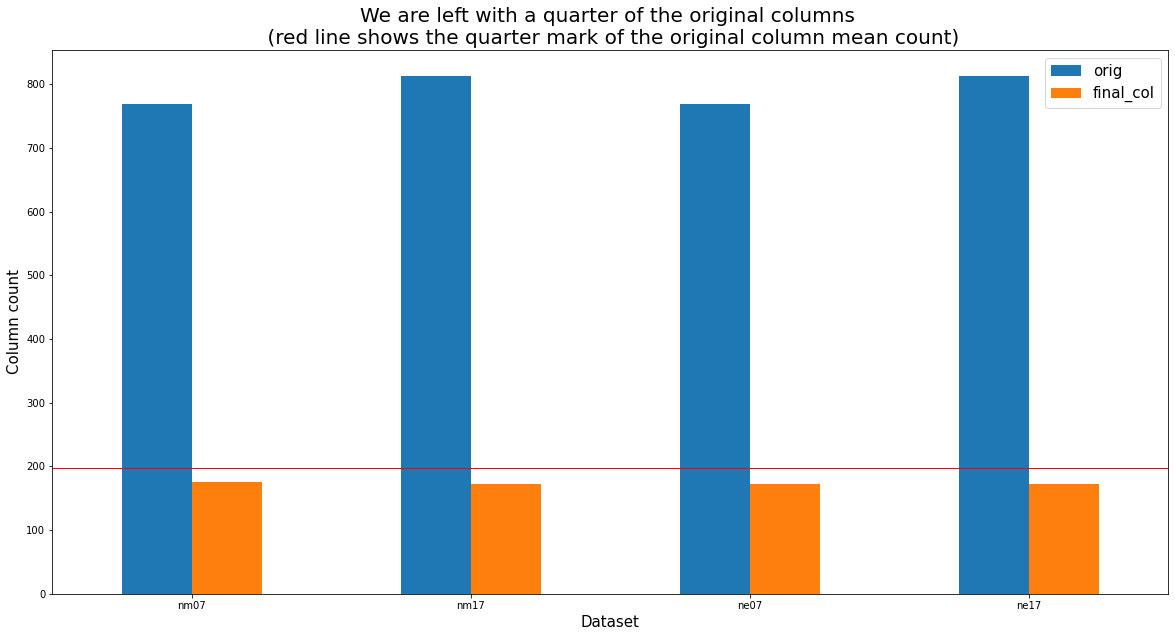

In [55]:
quarter = (all_df_att['orig'].mean())*.25

fig, ax = plt.subplots(figsize=(20,10))
all_df_att[['orig','final_col']].plot.bar(ax=ax)
plt.xlabel('Dataset',fontsize=15)
plt.ylabel('Column count',fontsize=15)
plt.xticks([0, 1, 2,3],labels=['nm07','nm17','ne07','ne17'],rotation=360)
plt.axhline(y=quarter,linewidth=1,color='r')
plt.legend(fontsize=15)
plt.title('We are left with a quarter of the original columns \n (red line shows the quarter mark of the original column mean count)',fontsize=20)
plt.savefig('./images/final_null.png');

#  Save Clean Files   <a id=exportclean><a>

In [51]:
nm07_target.reset_index(drop=True,inplace=True)
nm07 = nm07.assign(CAT_ELIG=nm07_target)
nm07 = nm07.astype('float64')
nm07.to_csv('./data/clean_nm07.csv',index=None)

In [52]:
nm17_target.reset_index(drop=True,inplace=True)
nm17 = nm17.assign(CAT_ELIG=nm17_target)
nm17 = nm17.astype('float64')
nm17.to_csv('./data/clean_nm17.csv',index=None)

In [53]:
ne07_target.reset_index(drop=True,inplace=True)
ne07 = ne07.assign(CAT_ELIG=ne07_target)
ne07 = ne07.astype('float64')
ne07.to_csv('./data/clean_ne07.csv',index=None)

In [54]:
ne17_target.reset_index(drop=True,inplace=True)
ne17 = ne17.assign(CAT_ELIG=ne17_target)
ne17 = ne17.astype('float64')
ne17.to_csv('./data/clean_ne17.csv',index=None)